## How does the initial state of eigenNets predict their future performance? 

I noticed in a few early examples that eigenNetworks have a huge variance in final performance, that seems due to the initial state. This is maybe similar to the "lottery ticket" hypothesis I read about a few years back. In this code, I'll train multiple implementations of eigenNets and save the initial state of each one. Then, I'll see if there is a way to predict final performance based on the initial state alone. 

I'll use two different implementations of eigenNets -- the first is the full eigenNet where every layers activations come from the projections onto eigenvectors. The second is the first-layer only eigenNet where only the first layers input comes from projections onto eigenvectors (the critical difference being that the input eigenvectors never change). 

In [1]:
%load_ext autoreload
%autoreload 2

from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

import os, sys
from glob import glob
import time
from tqdm import tqdm
import torch
import torchvision.transforms as transforms
import pickle
from pathlib import Path

import torch.nn as nn
import torch.nn.functional as F

sys.path.append("../") 
from deepnets import nnModels as models
from deepnets import nnEigenModels as eigModels
from deepnets import nnExperiments as nnexp
from deepnets import nnUtilities as nnutils

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

dataPath = None

Using device: cuda


In [2]:
# Define experiment settings
numEach = 10
iterations = 100
learningRate = None
if learningRate is not None:
    weightDecaySetting = learningRate * 1e-1
else:
    weightDecaySetting = 1e-3
dropoutSetting = 0.5
verbose = False
dataset = 'MNIST'

runExperiment = True
saveResults = True

if runExperiment:
    # Saving Parameters
    saveDir=Path('../data/predictEigenNetPerformance')
    if not os.path.exists(saveDir): os.makedirs(saveDir)

    # Run experiment
    pDropout = np.repeat([0,0],numEach)
    weightDecay = np.repeat([0,0],numEach)
    useNetID = np.repeat([1,1],numEach)
    fullResults = nnexp.predictEigenNetPerformanceByInit(useNetID=useNetID,pDropout=pDropout,weightDecay=weightDecay,iterations=iterations,learningRate=learningRate,dataset=dataset,DEVICE=DEVICE,verbose=verbose)
    
    if saveResults:
        fileName = f'predictEigenNetPerformance_{dataset}_{date.today()}.pkl'
        with open(saveDir / fileName, 'wb') as f:
            pickle.dump(fullResults, f)

Initiating experiment using cuda
Network 1/20 finished in 287.5 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.78. Test accuracy: 70.06%.
Network 2/20 finished in 282.0 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.14. Test accuracy: 97.99%.
Network 3/20 finished in 281.7 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.13. Test accuracy: 97.93%.
Network 4/20 finished in 281.4 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.13. Test accuracy: 98.00%.
Network 5/20 finished in 280.9 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.58. Test accuracy: 78.13%.
Network 6/20 finished in 281.2 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.14. Test accuracy: 97.79%.
Network 7/20 finished in 280.9 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.39. Test accuracy: 86.74%.
Network 8/20 finished in 281.2 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.77. Test accuracy: 70.27%.
Network 9/20 finished in 281.2 seconds. pDropout:0.0. WeightDecay:0. Test loss:0.13. Test accuracy: 97.

In [3]:
saveResults = False
if saveResults:
    fileName = f'predictEigenNetPerformance_{dataset}_{date.today()}.pkl'
    with open(saveDir / fileName, 'wb') as f:
        pickle.dump(fullResults, f)

In [4]:
pDropout = np.array([fr['pDropout'] for fr in fullResults])
weightDecay = np.array([fr['cWeightDecay'] for fr in fullResults])

numRuns = len(fullResults)
numLayers = len(fullResults[0]['alignFull'][0])
alignFull = [res['alignFull'] for res in fullResults]
alignMean = torch.stack([res['net'].avgFromFull(res['alignFull']) for res in fullResults])
alignLayer = [[] for _ in range(numLayers)]
for layer in tqdm(range(numLayers)):
    # First put each layers alignment trajectory as a list in alignLayer
    for runidx in range(numRuns):
        alignLayer[layer].append(fullResults[runidx]['net'].layerFromFull(alignFull[runidx],layer))
    # Then concatenate across them all, so we have a (numRuns, numNodes, numEpochs) tensor describing alignment trajectory
    alignLayer[layer] = torch.stack(alignLayer[layer])

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.38it/s]


In [7]:
alignMean.shape

torch.Size([20, 4, 11800])

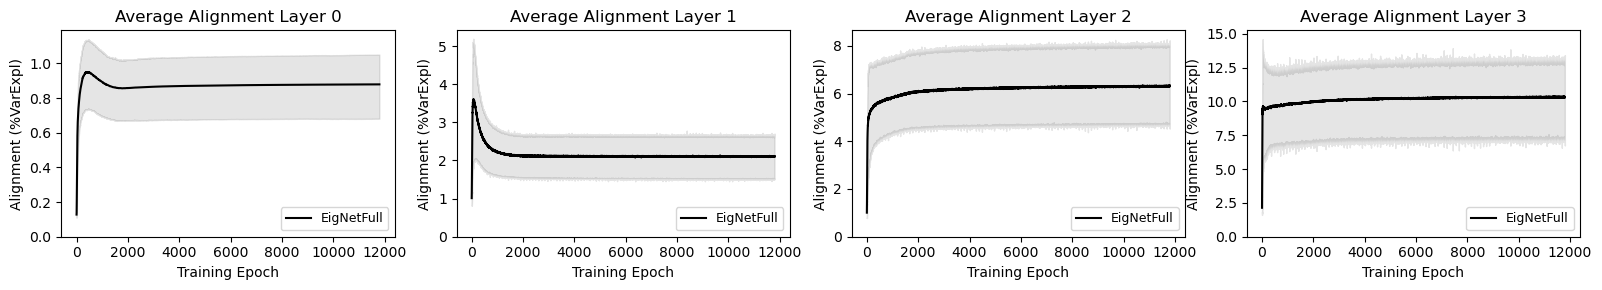

In [8]:
numEpoch = alignLayer[0].shape[2]

qRange = (0.2,0.8)

fig, ax = plt.subplots(1,numLayers,figsize=(16,3))
for layer in range(numLayers):
    mnFull = 100*torch.mean(alignMean[:,layer,:],dim=0)
    seFull = 100*torch.std(alignMean[:,layer,:],dim=0)
    uqFull = 100*torch.mean(torch.quantile(alignLayer[layer],q=qRange[1],dim=1),dim=0)
    lqFull = 100*torch.mean(torch.quantile(alignLayer[layer],q=qRange[0],dim=1),dim=0)
    
    ax[layer].plot(range(numEpoch), mnFull, c='k', linewidth=1.5, label='EigNetFull')
    
    # Interdecile range
    ax[layer].fill_between(range(numEpoch), uqFull, lqFull, color='k', alpha=0.1)
    
    # Labels
    ax[layer].set_ylim(0)
    ax[layer].set_xlabel('Training Epoch')
    ax[layer].set_ylabel('Alignment (%VarExpl)')
    ax[layer].set_title(f'Average Alignment Layer {layer}')
    ax[layer].legend(fontsize=9,loc='lower right')
    
plt.tight_layout()

In [10]:
# Measure final tset accuracy
finalTestAccuracy = np.array([nnutils.measurePerformance(fr['net'], fr['testloader'])[1].cpu().numpy() for fr in fullResults])

(20,)

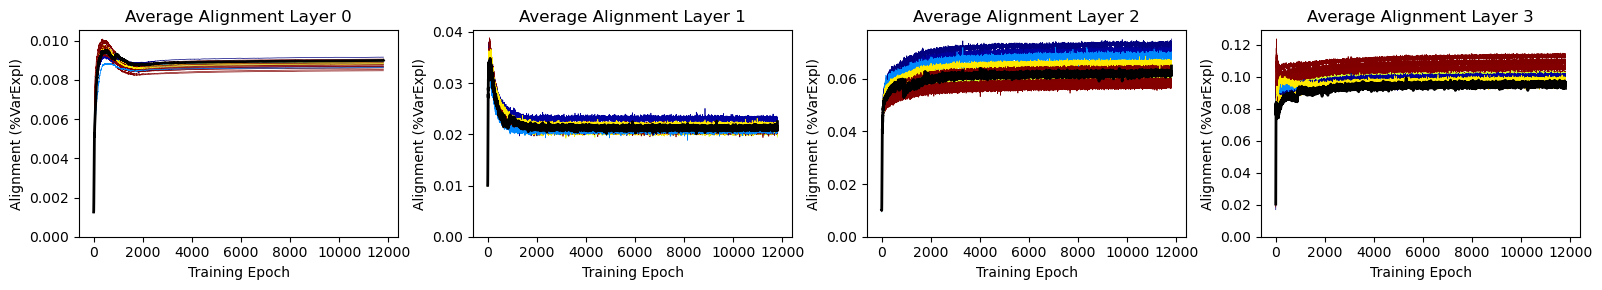

In [87]:
# Plot Alignment According to final test accuracy
colorNorm = colors.Normalize(vmin=np.min(finalTestAccuracy),vmax=np.max(finalTestAccuracy))
getColor = lambda s : cm.jet(colorNorm(s))

numEpoch = alignLayer[0].shape[2]

qRange = (0.2,0.8)

fig, ax = plt.subplots(1,numLayers,figsize=(16,3))
for layer in range(numLayers):
    for runidx in range(len(finalTestAccuracy)):
        ax[layer].plot(range(numEpoch), alignMean[runidx,layer,:], c=getColor(finalTestAccuracy[runidx]), linewidth=0.5)
    
    ax[layer].plot(range(numEpoch), alignMean[11,layer,:], c='k', linewidth=2)
    
    # Labels
    ax[layer].set_ylim(0)
    ax[layer].set_xlabel('Training Epoch')
    ax[layer].set_ylabel('Alignment (%VarExpl)')
    ax[layer].set_title(f'Average Alignment Layer {layer}')
    
plt.tight_layout()

In [33]:
initWeights[runidx].shape

torch.Size([784])

In [34]:
ceval0.shape

torch.Size([784])

In [38]:
torch.sum(ceval0*initWeights[runidx]) / torch.sum(ceval0)

tensor(0.3014)

In [41]:
len(fullResults[0]['allWeights'][0])

4

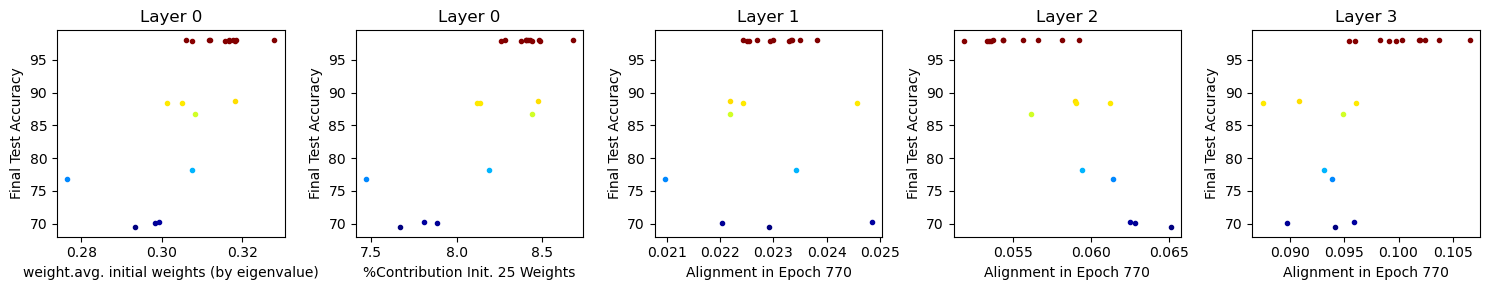

In [83]:
# Plot initial weight distribution according to final test accuracy
lookOver = np.arange(25) # how many weights to look from (sum of first N relative to sum of all weights, x100)
fig, ax = plt.subplots(1, numLayers+1, figsize=(15,3))

colorNorm = colors.Normalize(vmin=np.min(finalTestAccuracy),vmax=np.max(finalTestAccuracy))
getColor = lambda s : cm.jet(colorNorm(s))

# Also plot initial weight distribution of first layer, using a weight sum according to the eigenvalues
getWeightFromEpoch = 0
getAlignFromEpoch = 900
initWeights = [torch.cat([torch.mean(torch.abs(fr['initWeights'][layer]),dim=0,keepdim=True).cpu() for fr in fullResults],dim=0) for layer in range(numLayers)]
learnedWeights = [torch.cat([torch.mean(torch.abs(fr['allWeights'][getWeightFromEpoch][layer]),dim=0,keepdim=True).cpu() for fr in fullResults],dim=0) for layer in range(numLayers)]
for runidx in range(len(finalTestAccuracy)):
    ceval0 = fullResults[runidx]['net'].eval0.cpu()
    ax[0].plot(torch.sum(100*learnedWeights[0][runidx]/torch.sum(learnedWeights[0][runidx]) * ceval0) / torch.sum(ceval0), finalTestAccuracy[runidx], c=getColor(finalTestAccuracy[runidx]), marker='.')
    ax[0].set_xlabel('weight.avg. initial weights (by eigenvalue)')
    ax[0].set_ylabel('Final Test Accuracy')
    ax[0].set_title('Layer 0')
                     
for layer in range(numLayers):
    if layer==0:
        sInitWeights = 100 * torch.sum(learnedWeights[layer][:,lookOver],dim=1) / torch.sum(learnedWeights[layer],dim=1)
        for runidx in range(len(finalTestAccuracy)):
            ax[1+layer].plot(sInitWeights[runidx], finalTestAccuracy[runidx], c=getColor(finalTestAccuracy[runidx]),marker='.')
        ax[1+layer].set_xlabel(f"%Contribution Init. {len(lookOver)} Weights")
    else:
        for runidx in range(len(finalTestAccuracy)):
            ax[1+layer].plot(alignMean[runidx,layer,getAlignFromEpoch], finalTestAccuracy[runidx], c=getColor(finalTestAccuracy[runidx]),marker='.')
        ax[1+layer].set_xlabel(f"Alignment in Epoch {getAlignFromEpoch}")
        
    ax[1+layer].set_ylabel('Final Test Accuracy')
    ax[1+layer].set_title(f'Layer {layer}')
    
plt.tight_layout()

In [16]:
# Get final training and testing accuracy for all the trained networks
finalTrainAccuracy = np.array([fr['trackAccuracy'][-1] for fr in fullResults])
finalTestAccuracy = np.array([nnutils.measurePerformance(fr['net'], fr['testloader'])[1].cpu().numpy() for fr in fullResults])

Text(0, 0.5, 'Training Accuracy')

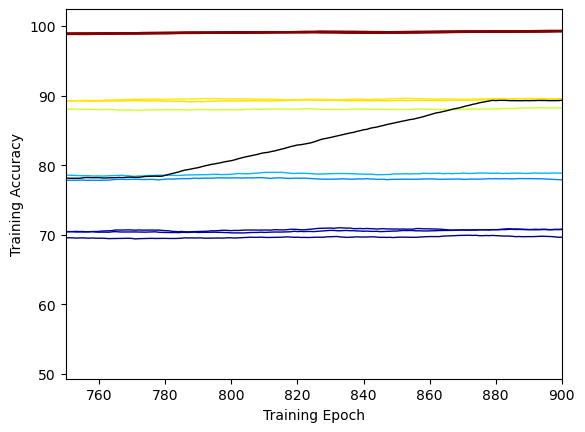

In [86]:
colorNorm = colors.Normalize(vmin=np.min(finalTestAccuracy),vmax=np.max(finalTestAccuracy))
getColor = lambda s : cm.jet(colorNorm(s))

smoothFunc = lambda x : np.convolve(x, np.ones(100)/100, 'valid')
allTrainAccuracy = np.array([smoothFunc(np.array(fr['trackAccuracy'])) for fr in fullResults]).T
for runidx in range(allTrainAccuracy.shape[1]):
    ccol = getColor(finalTestAccuracy[runidx])
    #plt.plot(range(allTrainAccuracy.shape[0]), allTrainAccuracy[:,runidx], c=getColor(finalTestAccuracy[runidx]), linewidth=1);
    if runidx==11: ccol='k'
    plt.plot(range(allTrainAccuracy.shape[0]), allTrainAccuracy[:,runidx], c=ccol, linewidth=1);

plt.xlim(750, 900)
plt.xlabel('Training Epoch')
plt.ylabel('Training Accuracy')

In [85]:
allTrainAccuracy[815,:]

array([70.38411461, 99.08333336, 99.0546875 , 99.1640625 , 78.96289062,
       99.12109375, 88.05273438, 70.69270836, 99.11263023, 99.05403648,
       89.26236984, 82.27539062, 99.04427086, 99.09309898, 69.64192711,
       99.10742188, 99.07226562, 99.01302086, 78.19075523, 89.41796875])

In [32]:
# Compare initial alignment to final performance?
# Compare initial weight distribution to final performance?
mnInitAlignment = np.array([torch.mean(alayer[1]).cpu().numpy() for alayer in alignLayer[0]])

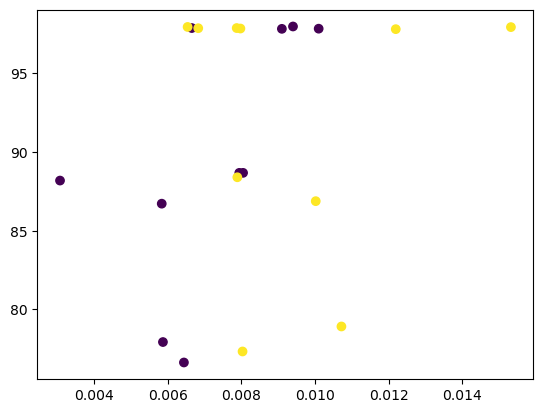

In [33]:
plt.scatter(mnInitAlignment, finalTestAccuracy, c=useNetID)

In [48]:
initWeights.shape

torch.Size([20, 784])

(-0.5, 100.5)

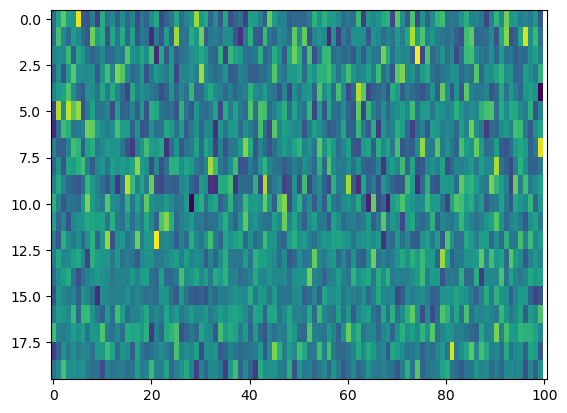

In [82]:
# Get Initial Weights
getLayer = 1
initWeights = torch.cat([torch.mean(torch.abs(fr['allWeights'][2300][getLayer]),dim=0,keepdim=True).cpu() for fr in fullResults],dim=0)
idxSortTest = np.argsort(finalTestAccuracy)
plt.imshow(initWeights.numpy(),aspect='auto')
plt.xlim(-0.5,100.5)

In [ ]:
mnInitAlignment.shape

(20,)

In [35]:
fullResults[0].keys()

dict_keys(['net', 'initWeights', 'allWeights', 'trackLoss', 'trackAccuracy', 'alignFull', 'trainloader', 'testloader', 'pDropout', 'cWeightDecay'])

In [56]:
len(fullResults[0]['allWeights'][0])

4